# Facebook Prophet - Lab

## Introduction

In the last lab, we learnt how to visualize and manipulate time series data, and how to use the ARIMA modeling to produce forecasts from time-series data. We also learnt how the conclude a correct parametrization of ARIMA models. This can be a complicated process, and while statistical programming languages such a R provide automated ways to solve this issue, but those have yet to be officially ported over to Python. 

Fortunately, the Data Science team at Facebook recently published a new method called prophet, which enables data analysts and developers alike to perform forecasting at scale in Python. We would encourage you to read [this article](https://research.fb.com/prophet-forecasting-at-scale/) by Facebook explaining how prophet simplifies the forecasting process and provides an improved predictive ability. 

## Objectives

* Understand the difference between ARIMA and Additive Synthesis for time series forecasting
* Model a time series object using prophet library 
* Make predictions for future and compare the approach with previously seen techniques

## Facebook Prophet

Facebook prophet uses an elegant yet simple method for analyzing and predicting periodic data known as the **additive modeling**. The idea is straightforward: represent a time-series as a combination of patterns at different scales such as daily, weekly, seasonally, and yearly, along with an overall trend. Your energy use might rise in the summer and decrease in the winter, but have an overall decreasing trend as you increase the energy efficiency of your home. An additive model can show us both patterns/trends and make predictions based on these observations.

The following image shows an additive model decomposition of a time-series into an overall trend, yearly trend, and weekly trend.

![](https://research.fb.com/wp-content/uploads/2017/02/prophet_example_for_post2.png?w=648)

*“Prophet has been a key piece to improving Facebook’s ability to create a large number of trustworthy forecasts used for decision-making and even in product features.”*

In order to compute its forecasts, the fbprophet library relies on the STAN programming language. Before installing fbprophet, we need to make sure that the pystan Python wrapper to STAN is installed. We shall first install `pystan` and `fbprophet` using `!pip install`.

In [1]:
#!pip install pystan

In [2]:
#!pip install --upgrade pip

In [3]:
#!pip install fbprophet

Let's start by reading in our time-series data. We shall cover some data manipulation using pandas, accessing financial data using the `Quandl` library and, and plotting with matplotlib. 

In [4]:
#Import necessary libraries
import warnings
warnings.filterwarnings('ignore')


import pandas as pd 

# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')

from fbprophet import Prophet as proph


In [5]:
# Import passengers.csv and set it as a time-series object. 
psg_df = pd.read_csv('passengers.csv')
psg_df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [6]:
psg_df.Month = pd.to_datetime(psg_df.Month)
psg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null datetime64[ns]
#Passengers    144 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.3 KB


The prophet library also imposes the strict condition that the input columns be named `ds` (the time column) and `y` (the metric column), so let's rename the columns in our `ts` dataframe. 

In [7]:
# Rename the columns [Month, AirPassengers] to [ds, y]
psg_df.rename(columns={'Month': 'ds', '#Passengers': 'y'}, inplace=True)
psg_df.head()
#    ds          y
# 1949-01-01	112
# 1949-02-01	118
# 1949-03-01	132
# 1949-04-01	129
# 1949-05-01	121

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
# Plot the timeseries 
psg_df.fillna(method='ffill')
psg_df.head(1)

,ds,y
0,1949-01-01,112


In [9]:
psg_df['ds'] = pd.DatetimeIndex(psg_df['ds'])
psg_df.set_index('ds')

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


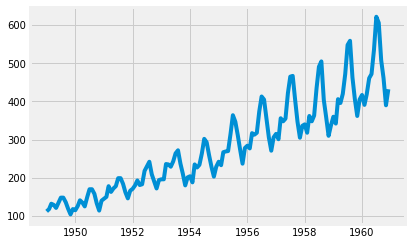

In [10]:
ax = plt.plot(psg_df['ds'], psg_df['y'])

# ax.set_ylabel('number of Airline Passengers/Month')
# ax.set_xlabel('Date')

plt.show();

## Time Series Forecasting with Prophet

In this section, we shall learn how to use the Prophet library to predict future values of our time-series. The Facebook team has abstracted away many of the inherent complexities of time series forecasting and made it more intuitive for analysts and developers alike to work with time series data.

To begin, we will create a new prophet object with `proph()` and provide a number of arguments. For example, we can specify the desired range of our uncertainty interval by setting the `interval_width` parameter.

In [11]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
Model = proph(interval_width=0.95)


Now that our model has been initialized, we can call its `fit` method with our DataFrame `ts` as input. The model fitting should take no longer than a few seconds.

In [12]:
# Fit the timeseries into Model
Model.fit(psg_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In order to obtain forecasts of our time series, we must provide the model with a new dataframe containing a `ds` column that holds the dates for which we want predictions. Conveniently, we do not have to concern ourselves with manually creating this dataframe because prophet provides the `make_future_dataframe` helper function. We will call this function to generate 36 datestamps in the future. The documentation for this function is available [HERE](https://www.rdocumentation.org/packages/prophet/versions/0.3.0.1/topics/make_future_dataframe).

It is also important to consider the frequency of our time series. Because we are working with monthly data, we clearly specified the desired frequency of the timestamps (in this case, MS is the start of the month). Therefore, the `make_future_dataframe` will generate 36 monthly timestamps for us. In other words, we are looking to predict future values of our time series 3 years into the future.


In [13]:
# USe make_future_dataframe with a monthly frequency and periods = 36 for 3 years
future_dates = Model.make_future_dataframe(periods=36, freq='MS')
future_dates.tail()

# 	ds
# 175	1963-08-01
# 176	1963-09-01
# 177	1963-10-01
# 178	1963-11-01
# 179	1963-12-01

,ds
175,1963-08-01
176,1963-09-01
177,1963-10-01
178,1963-11-01
179,1963-12-01


This future dates dataframe can now be used as input to the `predict` method of the fitted model.

In [14]:
# Predict the values for future dates and take the head of forecast
forecast = Model.predict(future_dates)
forecast.head()


# ds	trend	trend_lower	trend_upper	yhat_lower	yhat_upper	additive_terms	additive_terms_lower	additive_terms_upper	multiplicative_terms	multiplicative_terms_lower	multiplicative_terms_upper	yearly	yearly_lower	yearly_upper	yhat
# 0	1949-01-01	106.390966	106.390966	106.390966	40.066461	128.916059	-21.935305	-21.935305	-21.935305	0.0	0.0	0.0	-21.935305	-21.935305	-21.935305	84.455661
# 1	1949-02-01	108.569855	108.569855	108.569855	33.931775	120.662906	-30.703975	-30.703975	-30.703975	0.0	0.0	0.0	-30.703975	-30.703975	-30.703975	77.865881
# 2	1949-03-01	110.537884	110.537884	110.537884	65.902441	152.751003	-0.486998	-0.486998	-0.486998	0.0	0.0	0.0	-0.486998	-0.486998	-0.486998	110.050887
# 3	1949-04-01	112.716774	112.716774	112.716774	65.488925	149.317057	-5.184948	-5.184948	-5.184948	0.0	0.0	0.0	-5.184948	-5.184948	-5.184948	107.531826
# 4	1949-05-01	114.825377	114.825377	114.825377	67.562029	153.611413	-3.782347	-3.782347	-3.782347	0.0	0.0

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,106.390966,39.124227,127.877958,106.390966,106.390966,-21.935305,-21.935305,-21.935305,-21.935305,-21.935305,-21.935305,0.0,0.0,0.0,84.455661
1,1949-02-01,108.569855,34.322658,120.181603,108.569855,108.569855,-30.703975,-30.703975,-30.703975,-30.703975,-30.703975,-30.703975,0.0,0.0,0.0,77.865881
2,1949-03-01,110.537884,66.059197,153.237832,110.537884,110.537884,-0.486998,-0.486998,-0.486998,-0.486998,-0.486998,-0.486998,0.0,0.0,0.0,110.050887
3,1949-04-01,112.716774,64.391791,151.545735,112.716774,112.716774,-5.184948,-5.184948,-5.184948,-5.184948,-5.184948,-5.184948,0.0,0.0,0.0,107.531826
4,1949-05-01,114.825377,67.305245,155.535064,114.825377,114.825377,-3.782347,-3.782347,-3.782347,-3.782347,-3.782347,-3.782347,0.0,0.0,0.0,111.043030


We can see that prophet returns a large table with many interesting columns, but we subset our output to the columns most relevant to forecasting, which are:

* `ds`: the datestamp of the forecasted value
* `yhat`: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
* `yhat_lower`: the lower bound of our forecasts
* `yhat_upper`: the upper bound of our forecasts

In [16]:
# Subset above mentioned columns and view the tail 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# 	ds	yhat	yhat_lower	yhat_upper
# 175	1963-08-01	649.787427	604.921338	695.757506
# 176	1963-09-01	602.260711	557.213400	645.642244
# 177	1963-10-01	566.233600	524.324314	608.815224
# 178	1963-11-01	534.258296	488.622666	578.243727
# 179	1963-12-01	563.846779	516.242796	609.748779

,ds,yhat,yhat_lower,yhat_upper
175,1963-08-01,649.787427,603.017092,695.295787
176,1963-09-01,602.260711,557.895722,645.062636
177,1963-10-01,566.233600,520.344580,611.690812
178,1963-11-01,534.258296,491.317269,581.908091
179,1963-12-01,563.846779,518.168701,604.741905


A variation in values from the output presented above is to be expected as Prophet relies on Markov chain Monte Carlo (MCMC) methods to generate its forecasts. MCMC is a stochastic process, so values will be slightly different each time.

Prophet also provides a convenient function to quickly plot the results of our forecasts.

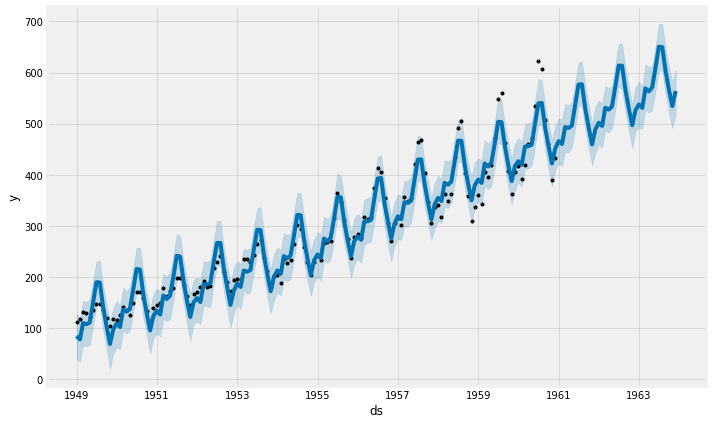

In [17]:
# Use prophet's plot function to plot the predictions
Model.plot(forecast, uncertainty=True)
plt.show()

Prophet plots the observed values of the time-series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values. We can use `plot_components()` function to view the individual components.

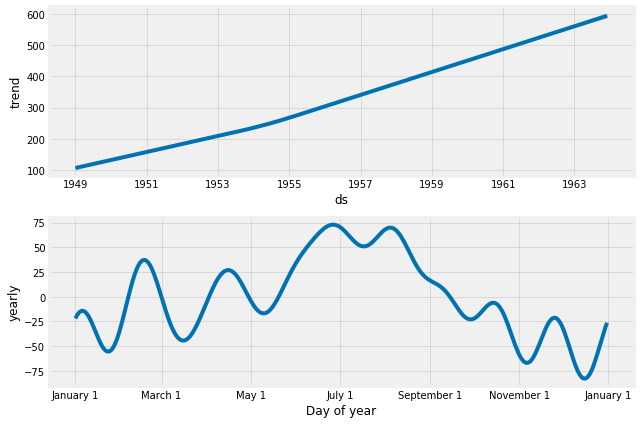

In [18]:
# Plot model components
Model.plot_components(forecast)
plt.show()


Since we are working with monthly data, Prophet will plot the trend and the yearly seasonality but if you were working with daily data, you would also see a weekly seasonality plot included.

From the trend and seasonality, we can see that the trend is a playing a large part in the underlying time series and seasonality comes into play mostly toward the beginning and the end of the year. With this information, we've been able to quickly model and forecast some data to get a feel for what might be coming our way in the future from this particular data set.

## Summary 
In this lab, you learned how to use the Prophet library to perform time series forecasting in Python. We have been using out-of-the box parameters, but Prophet enables us to specify many more arguments. In particular, Prophet provides the functionality to bring your own knowledge about time series to the table.